# Lab 2: Replicate and Extend Part of Michel et al 2011

## Define Functions

In [1]:
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy as sp
import scipy.optimize

""" Returns data and counts for a given language from file 1 of google n-grams
corpus, version 2. Files must be saved under the names provided when downloaded
from http://storage.googleapis.com/books/ngrams/books/datasetsv2.html"""
def get_data_counts(lang):
    data = pd.read_table("googlebooks-{}-all-1gram-20120701-1".format(lang), sep="\t", names=["ngram", "year", "match_count", "volume_count"], header=None, index_col=0)
    counts = pd.read_table("googlebooks-{}-all-totalcounts-20120701.txt".format(lang), sep=",", lineterminator="\t", names=["match_count", "page_count", "volume_count"], header=None, index_col=0)
    return data, counts

""" Creates plot of total match_count per year."""
def create_counts_plot(counts, language):
    plt.plot(counts.index, counts.match_count)
    plt.ylabel("Total Mention Counts")
    plt.title("Total Mention Count vs Year from Google n-gram corpus, Version 2 {}".format(language))
    plt.xlabel("Year")
    plt.show()
    plt.close()

""" Creates plot of ngrams using given information about n-gram and total counts
in a specified language. If frequency=True, creates plot of frequencies vs year.
If frequency=False, creates plot of raw counts vs year."""
def create_year_ngrams_plot(data, counts, language, frequency=True):
    ngrams = ['1883', '1910', '1950']
    plt.hold(True)
    for ngram in ngrams:
        # get ngram data
        subdata = data.loc[ngram]
        subdata = subdata.set_index(['year'])
        if frequency:
            frequenciesDf = pd.DataFrame(index=subdata.index, columns=['frequencies'])
            # get frequencies
            for i in subdata.index:
                frequenciesDf.loc[i]['frequencies'] = subdata.loc[i]['match_count'] * 1.0 / counts.loc[i]['match_count']
            # make plots
            plt.plot(frequenciesDf.index, frequenciesDf.frequencies)
            plt.ylabel("Frequency")
            plt.title("Frequency vs Year from Google n-gram corpus, Version 2 {}".format(language))
            plt.legend(ngrams)
        else:
            plt.plot(subdata.index, subdata.match_count)
            plt.ylabel("Mention Count")
            plt.title("Raw Mention Count vs Year from Google n-gram corpus, Version 2 {}".format(language))
            plt.legend(ngrams)
        plt.xlim([1850,2000])
        #plt.ylim([0,1.6])
        plt.xlabel("Year")
    plt.show()
    plt.close()

""" Creates plot of half-life vs year using provided n-gram and total count data
in a given language. If exponential=True, computes halflives by finding
exponential fit for data."""
def create_inset(data, counts, years, language, exponential=False):
    halflives = {}
    # get halflives
    for year in years:
        subset = data.loc[str(year)]
        subset = subset.set_index(['year'])
        frequenciesDf = pd.DataFrame(index=subset.index, columns=['frequencies'])
        # get frequencies
        for i in subset.index:
            frequenciesDf.loc[i]['frequencies'] = subset.loc[i]['match_count'] * 1.0 / counts.loc[i]['match_count']
        if exponential:
            halflife = compute_halflife_exponential(frequenciesDf, year)
        else:
            halflife = compute_halflife(frequenciesDf, year)
        # if halflife > 50:
        #     print("year: {}, halflife: {}".format(year, halflife))
        halflives[year] = halflife
    # create plot
    x = halflives.keys()
    y = halflives.values()
    plt.scatter(x,y,color="k")
    # best fit line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.ylabel("Half-life (yrs)")
    plt.title("Half-life vs Year from Google n-gram corpus, Version 2 {}".format(language))
    plt.xlabel("Year")
    plt.show()
    plt.close()

""" Computes half-life for year X by finding the first year after X for which
the frequency of the n-gram for X is less than half of the frequency in year X."""
def compute_halflife(df, year):
    start_index = df.index.get_loc(year, method='nearest')
    start = df.iloc[start_index]['frequencies']
    half_index = find_closest_val_index(df, start_index, start / 2.0)
    half_year = df.index[half_index]
    return int(half_year) - int(year)

""" Computes half-life for year X by finding an exponential fit for frequencies
of 1-gram X starting from year X. Half-life = ln(2)/lambda."""
def compute_halflife_exponential(df, year):
    start_index = df.index.get_loc(year, method='nearest')
    start_freq = df.iloc[start_index]['frequencies']
    freqs = df.iloc[start_index :]['frequencies'].values
    years = df.iloc[start_index :].index.astype(int).values
    log_freqs = np.log(freqs.astype(float))
    """ freq = A*e^{B * year}+start_freq -> log(freq-start_freq) = logA + year * B
    fit[0] = B, fit[1] = logA -> A = e^{fit[1]} """
    fit = np.polyfit(years, log_freqs, 1)
    """ NOTE: Uncomment to view fitted exponential against actual values. """
    
    # fig, ax = plt.subplots(1,1)
    # ax.plot(years, freqs)
    # ax.plot(years, np.exp(fit[1]) * np.exp(years * fit[0]))
    # plt.legend(['Actual', 'Fitted'])
    # plt.show()
    
    """ For freq = Ae^{-x*year}, half life is ln2/x.
    From the fit, -x = fit[0] -> halflife = ln2/(-fit[0]) """
    return np.log(2) * 1.0 / (-fit[0])

""" Finds the first index of a data frame for which the 'frequencies' column is
less than or equal to a given value. Returns -1 if all values in the
'frequencies' column are greater than the given value. """
def find_closest_val_index(df, start_index, value):
    for i in range(start_index, len(df.index) - 1):
        if df.iloc[i]['frequencies'] <= value:
            return i
    return -1

## Setup

In [2]:
%matplotlib inline
languages = {'English':'eng', 'Chinese':'chi-sim', 'French':'fre', 'German':'ger', 'Hebrew':'heb', 'Italian':'ita', 'Russian':'rus', 'Spanish':'spa'}
years = range(1800, 2000)

## Total Corpus Size by Year, Separated by Language

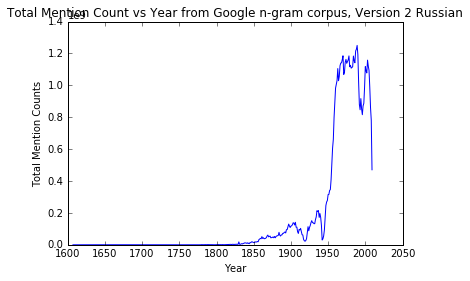

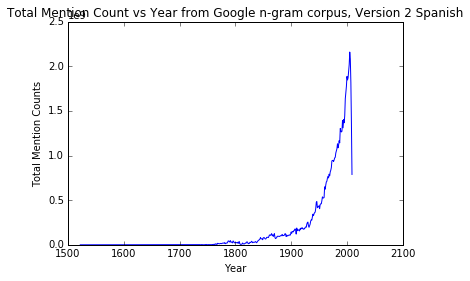

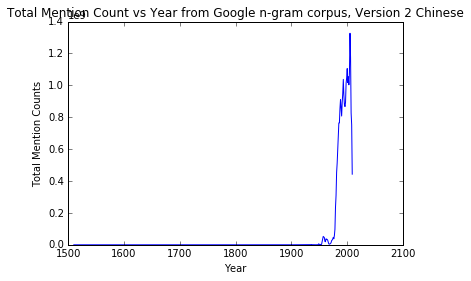

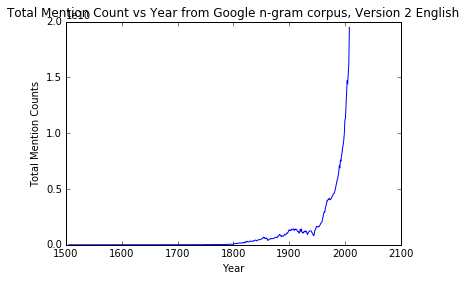

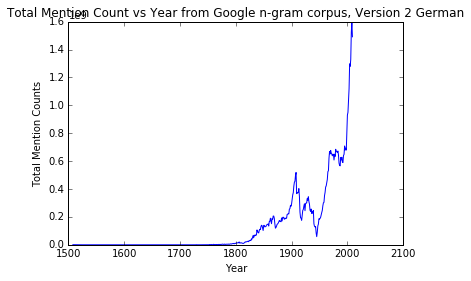

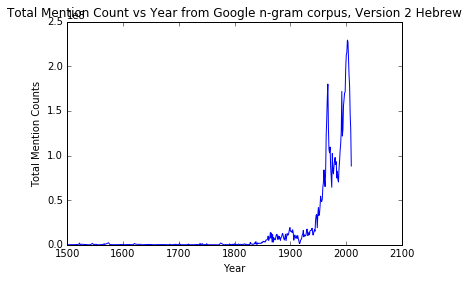

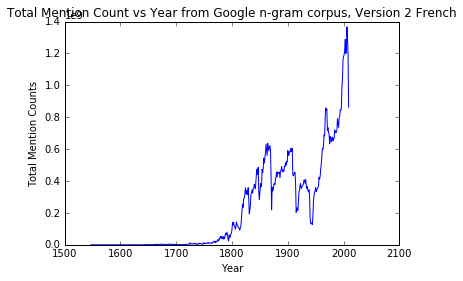

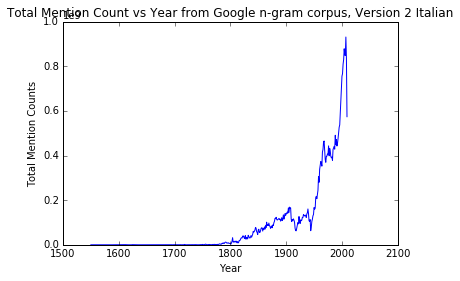

In [3]:
for lang, abbrv in languages.iteritems():
    counts = pd.read_table("googlebooks-{}-all-totalcounts-20120701.txt".format(abbrv), sep=",", lineterminator="\t", names=["match_count", "page_count", "volume_count"], header=None, index_col=0)
    create_counts_plot(counts, lang)

## Frequencies by Year, Separated by Language

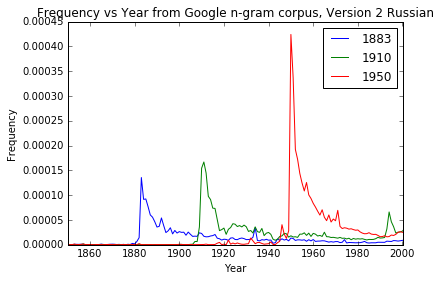

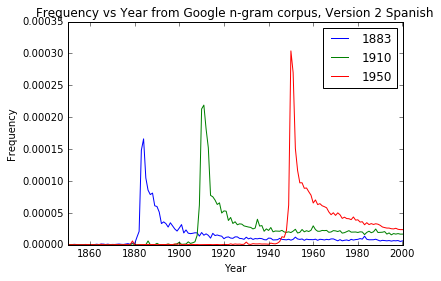

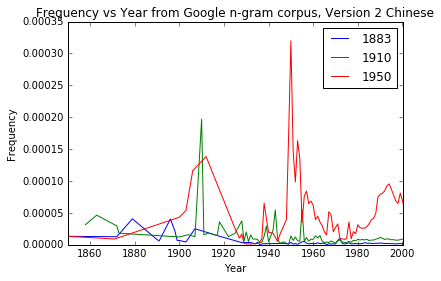

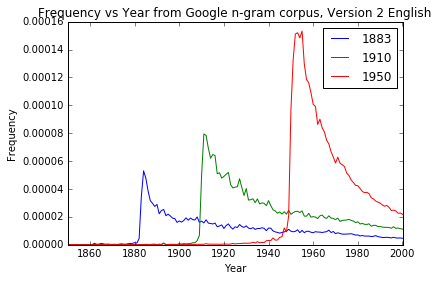

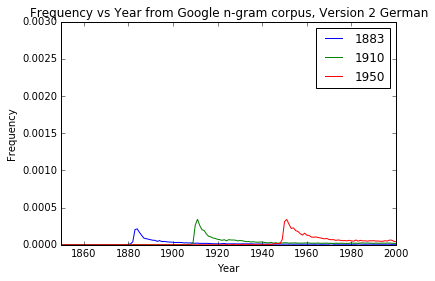

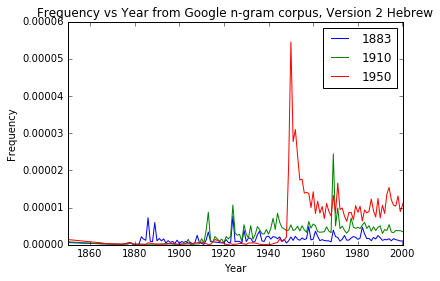

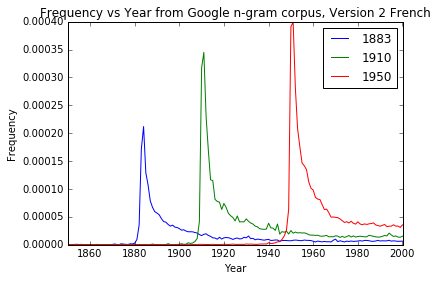

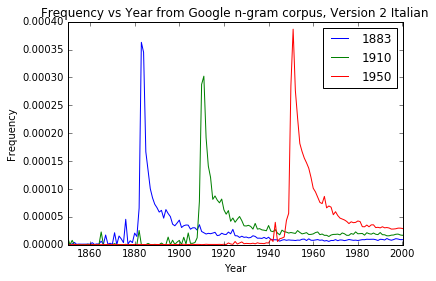

In [4]:
languages = {'English':'eng', 'Chinese':'chi-sim', 'French':'fre', 'German':'ger', 'Hebrew':'heb', 'Italian':'ita', 'Russian':'rus', 'Spanish':'spa'}
years = range(1800, 2000)
for lang, abbrv in languages.iteritems():
    data, counts = get_data_counts(abbrv)
    create_year_ngrams_plot(data, counts, lang, frequency=True)

## Raw Counts by Year, Separated by Language

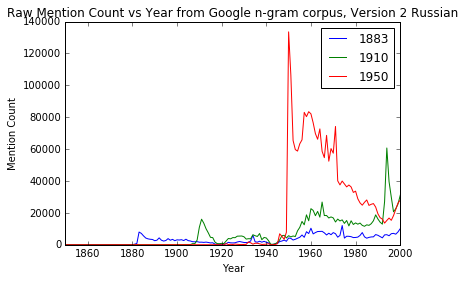

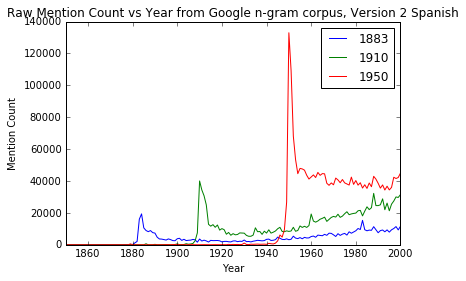

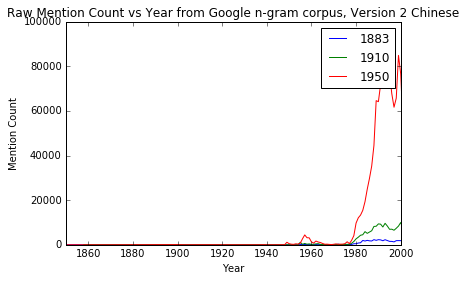

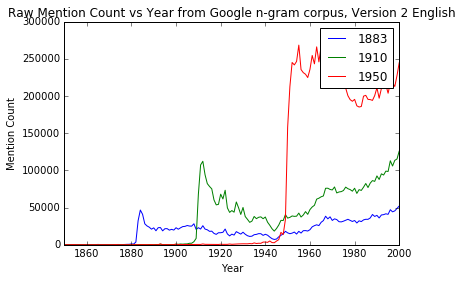

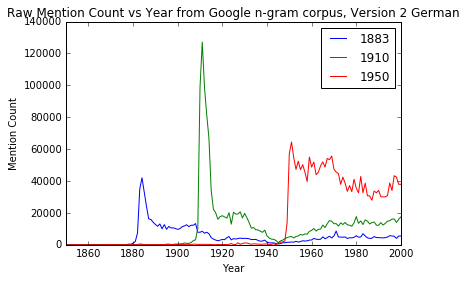

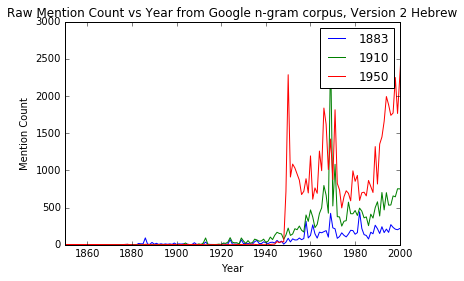

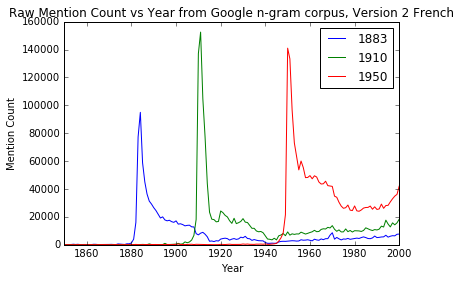

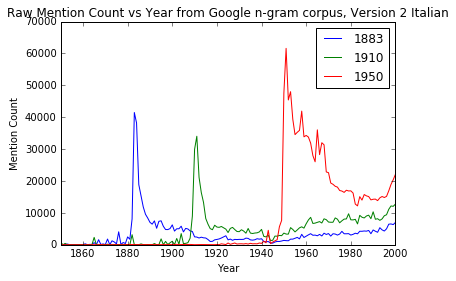

In [5]:
for lang, abbrv in languages.iteritems():
    data, counts = get_data_counts(abbrv)
    create_year_ngrams_plot(data, counts, lang, frequency=False)

## Halflives by Year, Separated by Language

Compute half-lives for year X by finding first year, Y, after year X for which frequency of n-gram X in year Y is at most half the frequency of n-gram X in year X

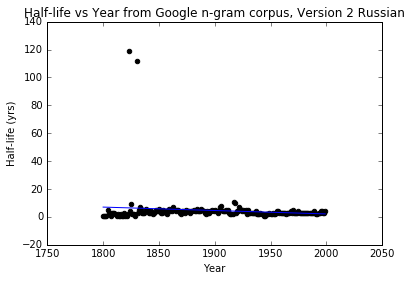

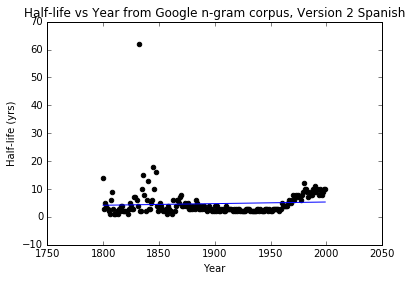

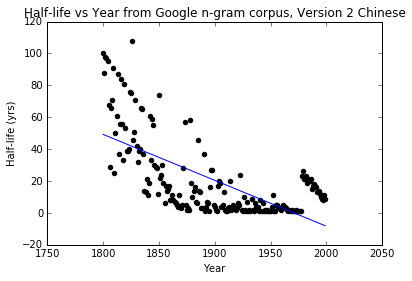

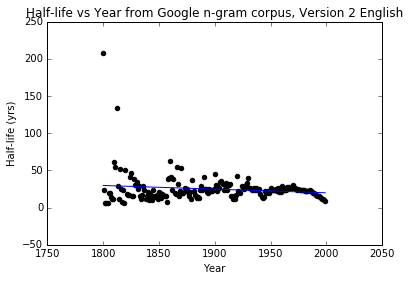

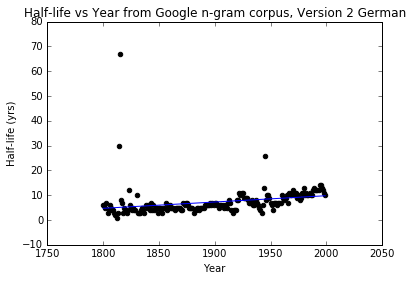

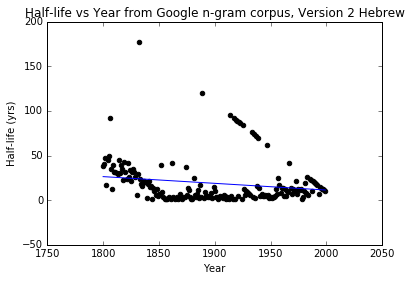

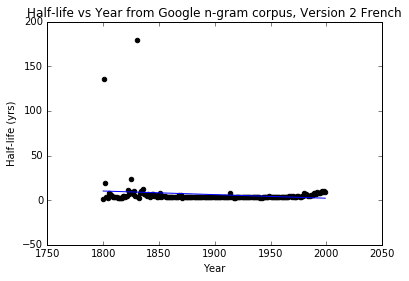

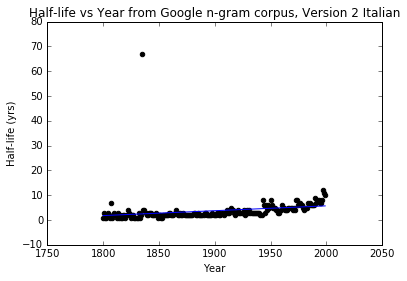

In [ ]:
for lang, abbrv in languages.iteritems():
    data, counts = get_data_counts(abbrv)
    create_inset(data, counts, years, lang)

Compute half-lives for year X by finding exponential fit for n-gram X frequency data starting from year X

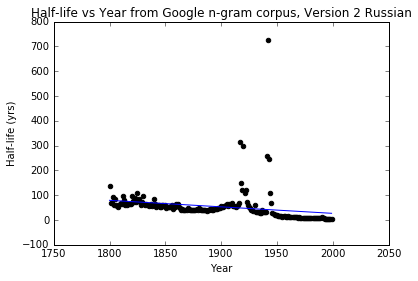

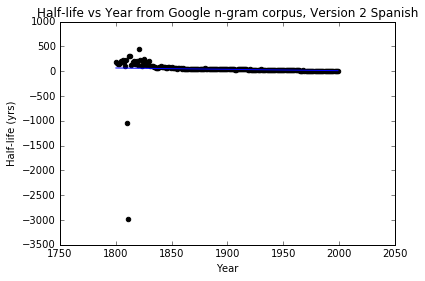

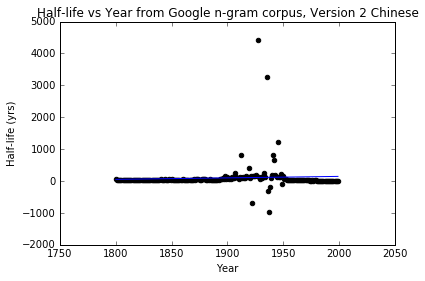

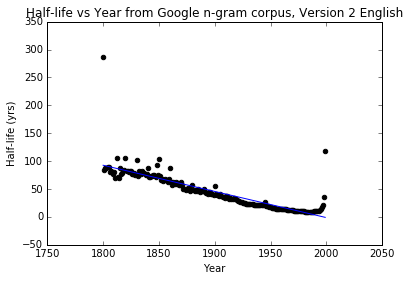

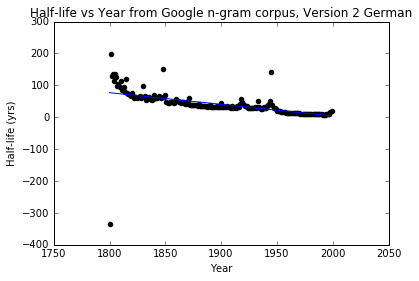

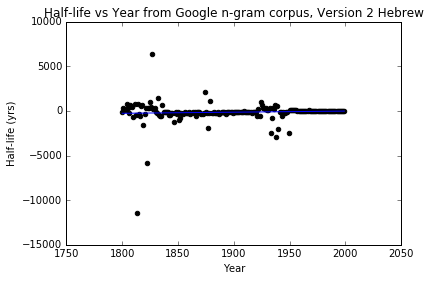

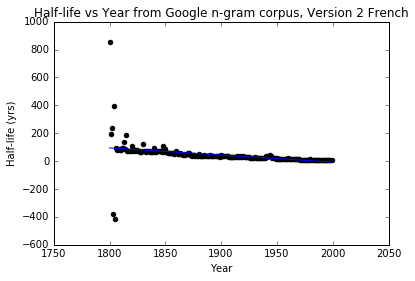

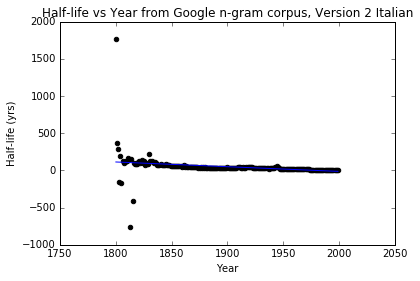

In [ ]:
for lang, abbrv in languages.iteritems():
    data, counts = get_data_counts(abbrv)
    create_inset(data, counts, years, lang, exponential=True)

## Plot Everything (faster)

Russian


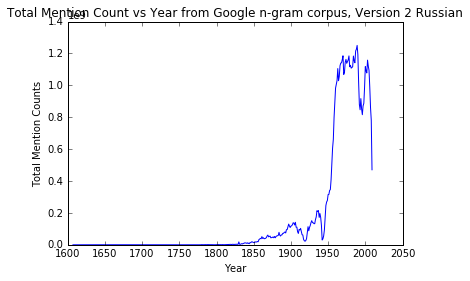

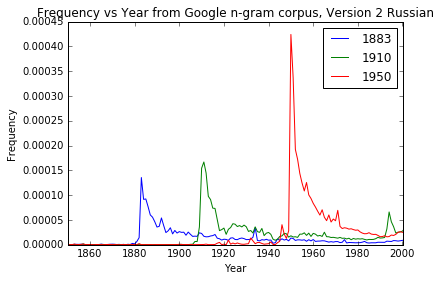

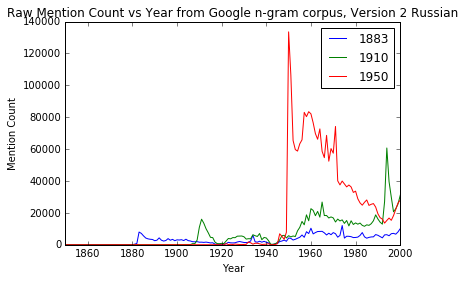

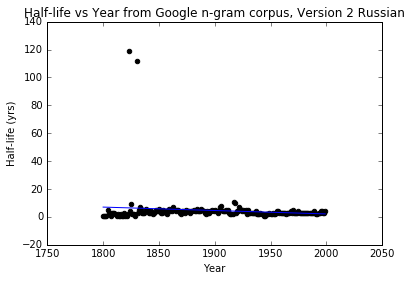

Spanish


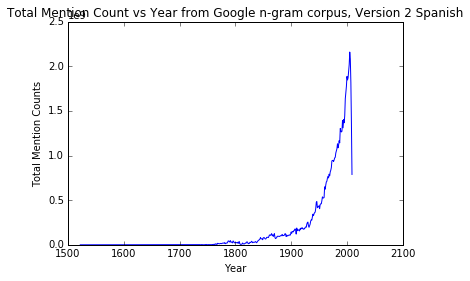

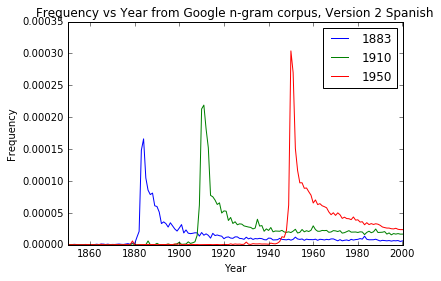

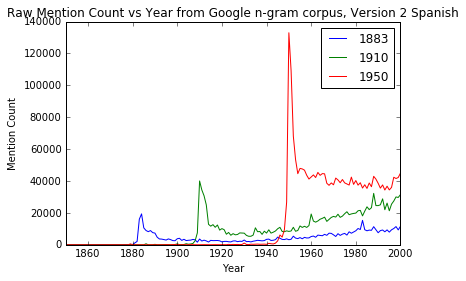

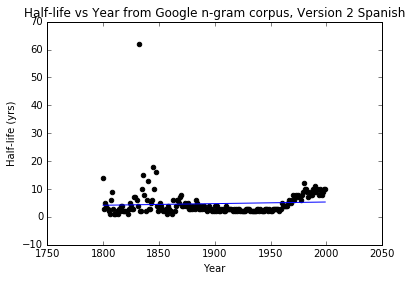

Chinese


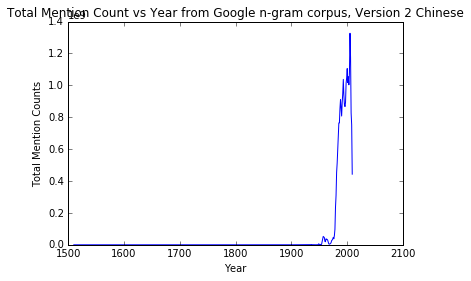

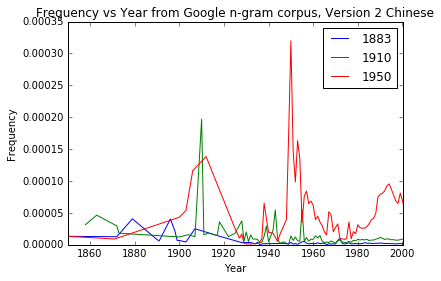

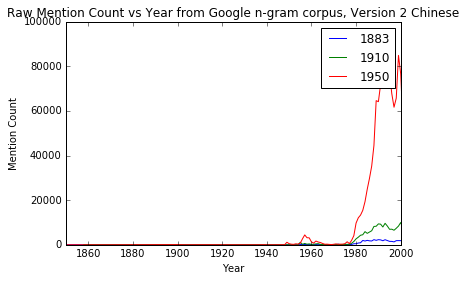

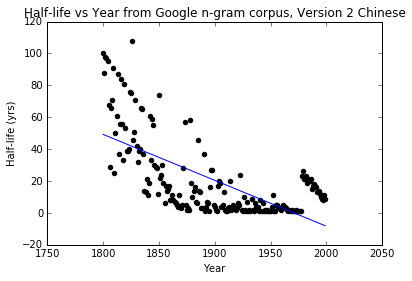

English


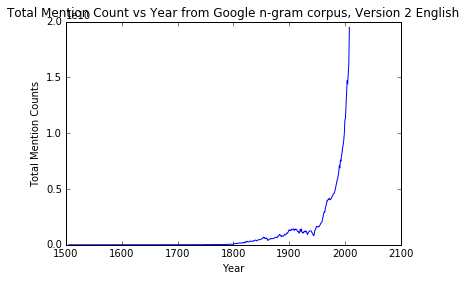

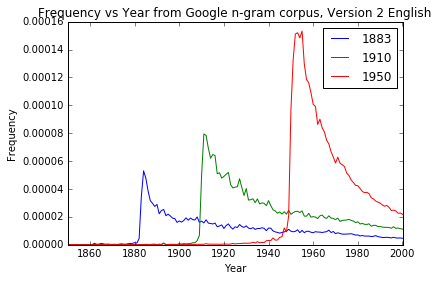

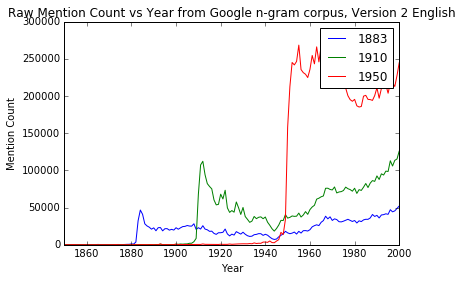

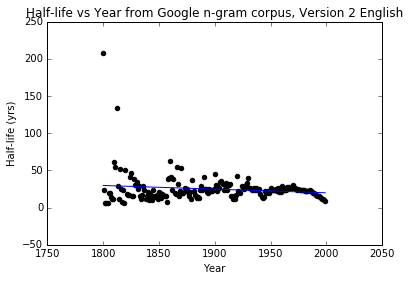

German


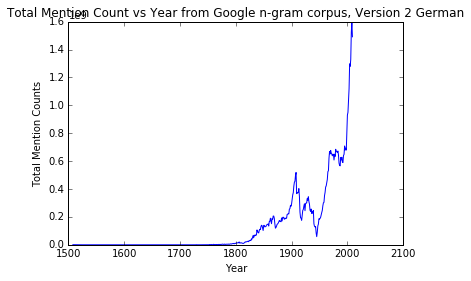

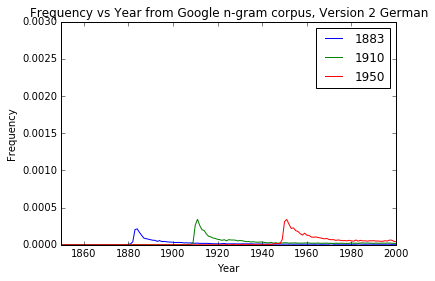

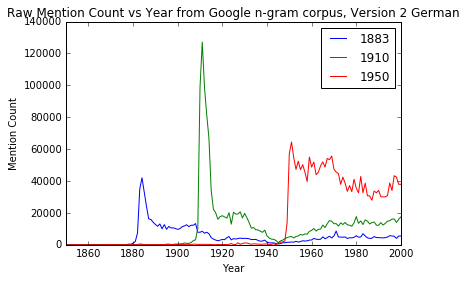

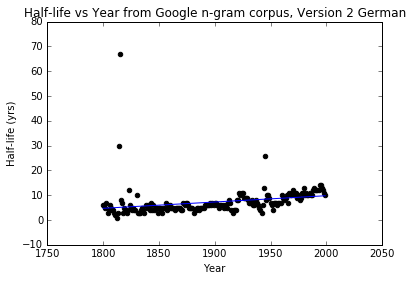

Hebrew


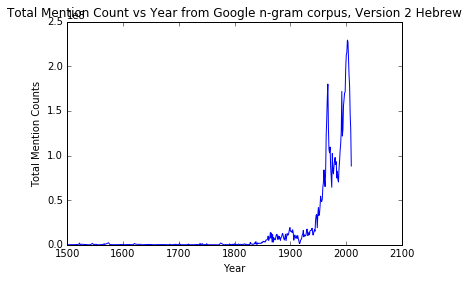

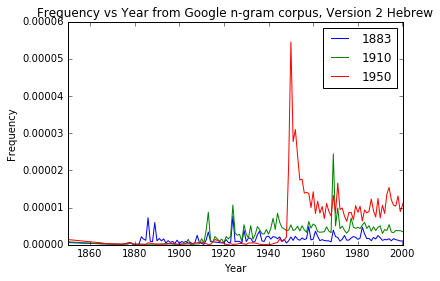

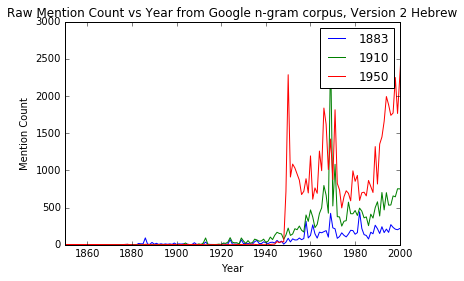

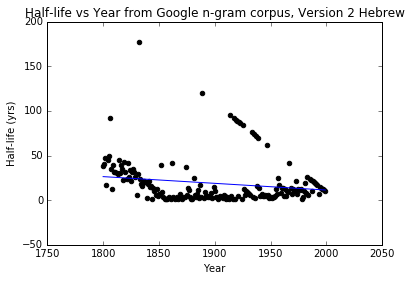

French


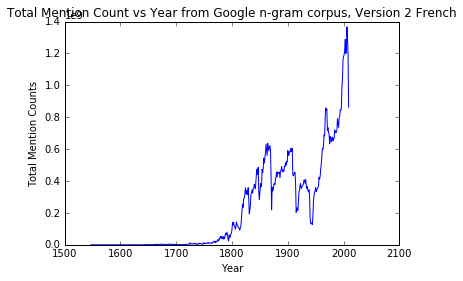

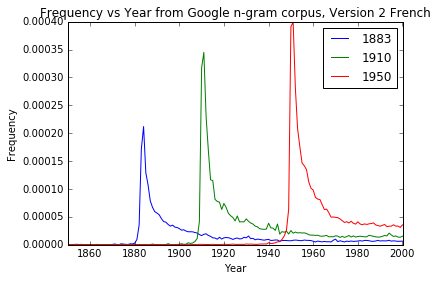

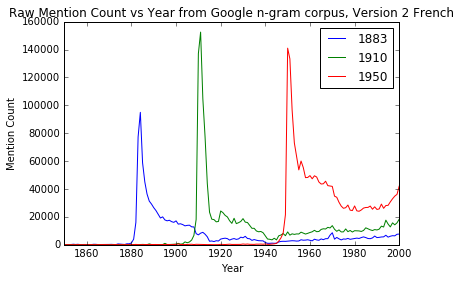

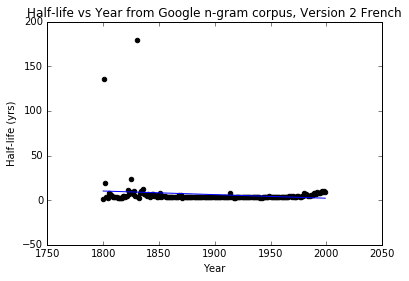

Italian


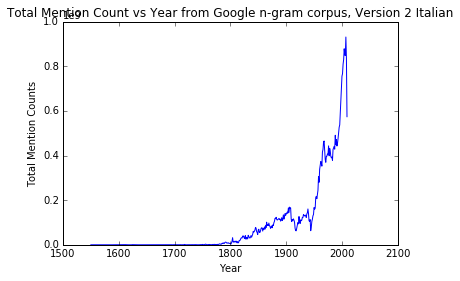

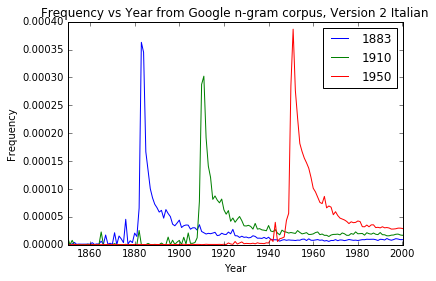

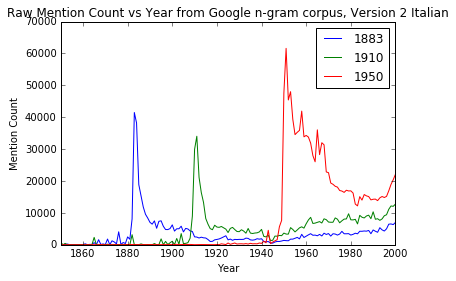

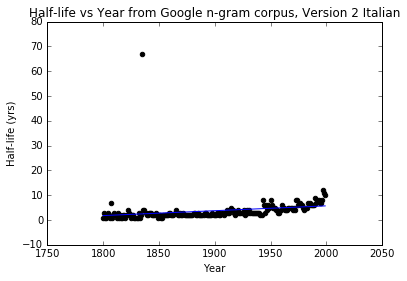

In [ ]:
for lang, abbrv in languages.iteritems():
    print(lang)
    data, counts = get_data_counts(abbrv)
    create_counts_plot(counts, lang)
    create_year_ngrams_plot(data, counts, lang, frequency=True)
    create_year_ngrams_plot(data, counts, lang, frequency=False)
    create_inset(data, counts, years, lang)